In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path

In [3]:
A_DPATH = Path('/gws/nopw/j04/iecdt/computer-vision-data/cam_a/imgs/../rectified_imgs')
B_DPATH = Path('/gws/nopw/j04/iecdt/computer-vision-data/cam_b/imgs/../rectified_imgs')

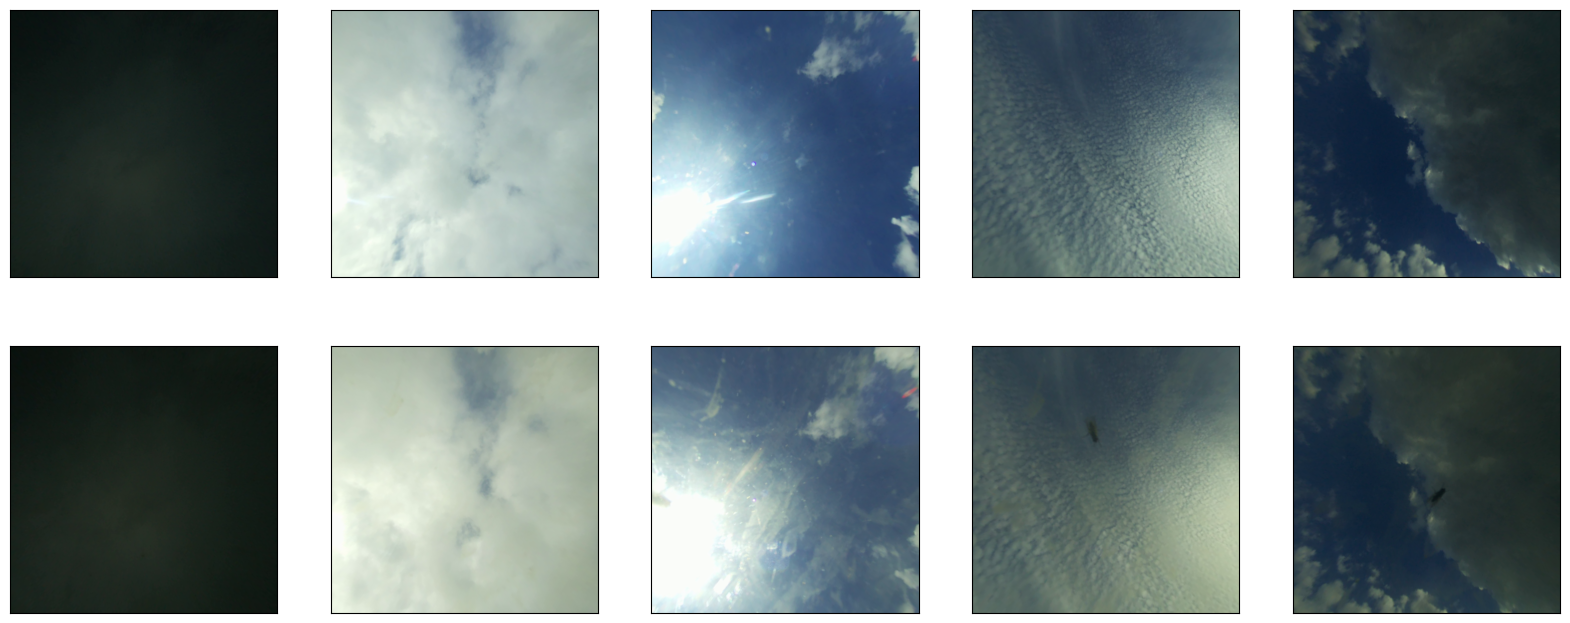

In [4]:
#Plot some matched examples from the rectified images with camera A on top and camera B on the bottom
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
for i in range(5):
    n = np.random.randint(0,13760)
    ax[0,i].imshow(plt.imread(list((A_DPATH).glob('*.png'))[n]))
    ax[1,i].imshow(plt.imread(list((B_DPATH).glob('*.png'))[n]))

1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918


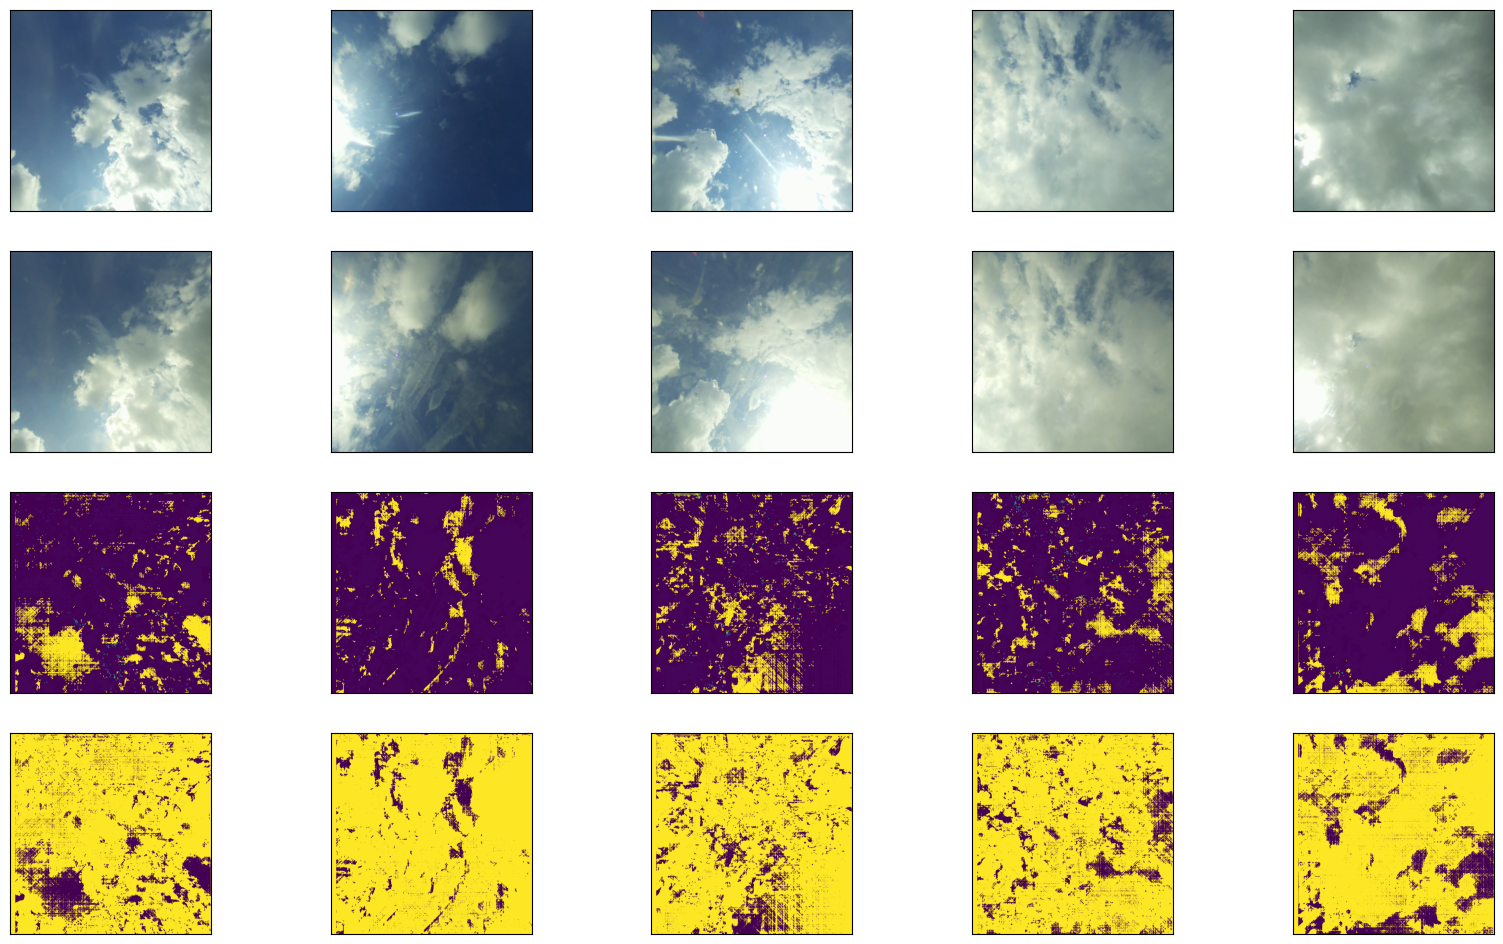

In [28]:
num_disparities = 16*10


# Camera parameters (from calibration)
focal_length = 2708  # Adjust based on your camera calibration
baseline = 271  # Distance between the cameras in meters


fig, ax = plt.subplots(4, 5, figsize=(20, 12))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
for i in range(5):
    n = np.random.randint(0,13760)
    

    # Load stereo images (left and right)
    img_left = cv2.imread(list((A_DPATH).glob('*.png'))[n], cv2.IMREAD_COLOR)
    img_right = cv2.imread(list((B_DPATH).glob('*.png'))[n], cv2.IMREAD_COLOR)
    image_left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    image_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

    ax[0,i].imshow(image_left_rgb)
    ax[1,i].imshow(image_right_rgb)

    # Create SGM matcher
    sgm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16*5,  # Should be a multiple of 16
        blockSize=5,
        P1=8 * 3 * 5**2,  # 8 * number_of_channels * blockSize^2
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=100,
        speckleRange=32
    )

    # Compute disparity map
    disparity = sgm.compute(img_left, img_right)

    # Normalize and display
    disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity_vis = np.uint8(disparity_norm)

    ax[2,i].imshow(disparity_vis)

    print(disparity.max(), disparity.min())


    # Disparity is set to float
    disparity = disparity.astype(np.float32)

    # Avoid division by zero
    disparity[disparity <= 0] = 1e-6  # Prevent infinite depth

    depth_map = (focal_length * baseline) / disparity

    print(disparity.max(), depth_map.min())

    # Display depth map
    depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = np.uint8(depth_vis)

    ax[3,i].imshow(depth_vis)

#cv2.waitKey(0)
#cv2.destroyAllWindows()

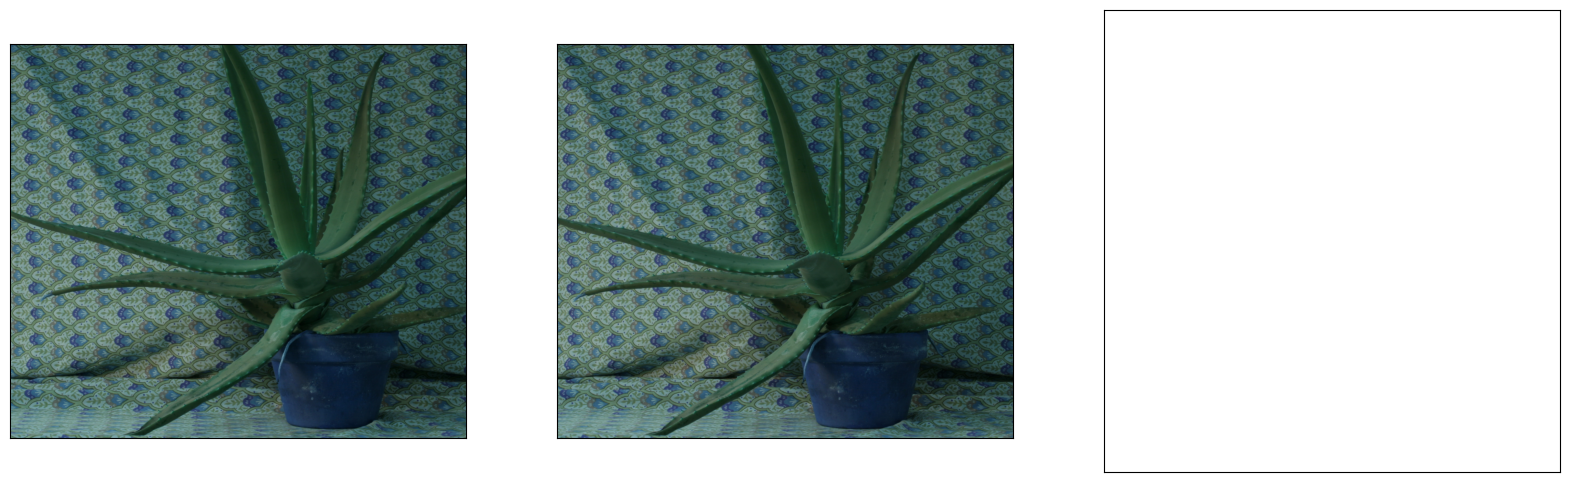

In [5]:

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])

imgL = cv2.imread('Aloe1.png', cv2.IMREAD_COLOR)
imgR = cv2.imread('Aloe2.png', cv2.IMREAD_COLOR)

ax[0].imshow(imgL)
ax[1].imshow(imgR)

num_disparities = 16*10

# Camera parameters (from calibration)
focal_length = 2708  # Adjust based on your camera calibration
baseline = 271  # Distance between the cameras in meters


# Load stereo images (left and right)
image_left_rgb = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
image_right_rgb = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# Create SGM matcher
sgm = cv2.StereoSGBM_create(
    minDisparity=16,
    numDisparities=16*6,  # Should be a multiple of 16
    blockSize=16,
    P1=216,  # 8 * number_of_channels * blockSize^2
    P2=864,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)


In [6]:

win_size = 3
min_disp = 16;             # 0
num_disp = 112 - min_disp; # fix(w/8) + 15
cn = 3
#num_disp = double(bitand(int32(num_disp), int32(-16))); # divisible by 16
stereo = cv2.StereoSGBM(MinDisparity=min_disp, NumDisparities=96, 
    BlockSize=16, P1=8*cn*win_size^2, P2=32*cn*win_size^2, 
    Disp12MaxDiff=1, UniquenessRatio=10, 
    SpeckleWindowSize=100, SpeckleRange=32, Mode='SGBM')


In [ ]:
# Compute disparity map
disparity = stereo.compute(imgL, imgR)
print('crash')


: 

In [ ]:


# Normalize and display
disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_vis = np.uint8(disparity_norm)

ax[2].imshow(disparity_vis)

print(disparity.max(), disparity.min())


# # Disparity is set to float
# disparity = disparity.astype(np.float32)

# # Avoid division by zero
# disparity[disparity <= 0] = 1e-6  # Prevent infinite depth

# depth_map = (focal_length * baseline) / disparity

# print(disparity.max(), depth_map.min())

# # Display depth map
# depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
# depth_vis = np.uint8(depth_vis)

# ax[3,i].imshow(depth_vis)
